<h1><center>Predicting <i>Fair</i> WTI Price using the EIA Weekly Petroleum Stock Report</center></h1>

<div class="alert alert-block alert-info">
    <b>What Is the EIA Petroleum Status Report?</b>
    <br>
    The EIA Petroleum Status Report is published every Wednesday by the U.S. Energy Information Administration (EIA), an agency within the U.S. Department of Energy. 
    <br>
    It details the level of crude-oil reserves that the U.S. holds, as well as the amount of crude and related products it produces, both domestically and abroad. (<a href=https://www.investopedia.com/terms/e/eia-petroleum-status-report.asp>Source</a>)
    <br><br>
    Table 1 of the report is the <b>U.S. Petroleum Balance Sheet</b>. This table contains inventory levels for Commercial Crude Oil and distillates, as well as the US Strategic Petroleum Reserve (SPR). These stock levels for all archived reports since August 2011 are stored in <i>reports.csv</i>.
    <br><br>
    <b>Aim: Investigate the relationship between inventory levels and the WTI spot price.</b>
</div>

<h1>Loading Data</h1>

In [1]:
import math
import pandas as pd
import numpy as np
import datetime as dt

import pytz

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

mpl.rcParams.update({
    "axes.grid" : True,
    "figure.figsize": (12,6)
    }
)

wall_st = pytz.timezone("America/New_York")

<h2 align="left"> <font color='32a8a6'>WPSR Inventory Data</font></h2>

In [2]:
inventory_data = pd.read_csv('./reports.csv', index_col=0)

In [3]:
def format_inventory_data(df: pd.DataFrame) -> pd.DataFrame:
    ''' Formats a Petroleum Supply table from the WPSR.

    * Extracts report date from the file endpoint for use over inventory date.
    * Localises the report date to EST.
    * Drops non-inventory columns.

    Arguments
    =========
    df : pd.DataFrame
        DataFrame containing Petroleum Supply inventory data

    Returns
    =======
    df : pd.DataFrame
        Reformatted DataFrame
    '''
    # Extract report date from endpoint url
    df['Report Date'] = df['Endpoint'].str.extract(r'(\d{4}_\d{2}_\d{2})')
    # Drop URL, Report Date
    df = df.drop('Endpoint', axis=1)
    df = df.reset_index(drop=True)
    # Set report date as index, convert to DatetimeIndex
    df = df.set_index('Report Date')
    df.index = pd.to_datetime(df.index, format='%Y_%m_%d').tz_localize(wall_st)
    return df

In [4]:
inv = format_inventory_data(inventory_data)

In [5]:
inv['Commercial Crude'] = inv['Crude Oil'] - inv['SPR']

In [6]:
inv.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 668 entries, 2011-08-03 00:00:00-04:00 to 2024-05-15 00:00:00-04:00
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Crude Oil                     668 non-null    float64
 1   Total Motor Gasoline          668 non-null    float64
 2   Fuel Ethanol                  668 non-null    float64
 3   Kerosene-Type Jet Fuel        668 non-null    float64
 4   Distillate Fuel Oil           668 non-null    float64
 5   Residual Fuel Oil             668 non-null    float64
 6   Propane/Propylene             668 non-null    float64
 7   Other Oils                    668 non-null    float64
 8   Unfinished Oils               668 non-null    float64
 9   Total Stocks (Including SPR)  668 non-null    float64
 10  Total Stocks (Excluding SPR)  668 non-null    float64
 11  SPR                           668 non-null    float64
 12  Commercial Crud

<h2 align="left"> <font color='32a8a6'>WTI Spot Price Data</font></h2>

We can get daily price data for the WTI spot price from the Yahoo Finance API.

In [7]:
import yfinance as yf

In [8]:
first_inventory_date = inv.index.min()
last_inventory_date = inv.index.max()

In [9]:
today = dt.datetime.now(tz=wall_st)
days_per_year = 365.2425
years_ago = int(( today - first_inventory_date).days // days_per_year) + 1

In [10]:
wti = yf.Ticker("CL=F")
hist = wti.history(period=f"{years_ago}y")  # get relevant historical data from Yahoo Finance

In [11]:
hist.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2011-05-24 00:00:00-04:00,97.540001,100.089996,96.610001,99.589996,339530,0.0,0.0
2011-05-25 00:00:00-04:00,99.269997,101.629997,98.199997,101.320000,354880,0.0,0.0
2011-05-26 00:00:00-04:00,101.239998,101.900002,99.610001,100.230003,332135,0.0,0.0


We use percentage change here to account for varying prices over time.

<h2 align="left"> <font color='32a8a6'>Useful Aggregations</font></h2>

In [12]:
report_dates = inv.index

In [13]:
# Daily Price data
prices_day_of = hist.loc[report_dates].copy()

changes_day_of = 100 * (prices_day_of['Close'] - prices_day_of['Open']) / prices_day_of['Open']

In [14]:
# Week-following Price data
_agg_prices = hist.loc[inv.index[0]:inv.index[-1] + dt.timedelta(days=6)]
_last_report = report_dates.searchsorted(_agg_prices.index, side='right') - 1

ohlc_agg = {
    'High': 'max',
    'Low': 'min',
    'Open': 'first',
    'Close': 'last',
    'Volume': 'sum'
}

prices_week_after = _agg_prices.groupby(report_dates[_last_report]).agg(ohlc_agg)
changes_week_after = 100 * (prices_week_after['Close'] - prices_week_after['Open']) / prices_week_after['Open']

<h1>Investigating Inventory - Price Correlation</h1>

<div class="alert alert-block alert-info">
    The Pearson correlation coefficient (PCC) is a correlation coefficient that measures <b>linear correlation</b> between two sets of data. It is the ratio between the covariance of two variables and the product of their standard deviations; thus, it is essentially a normalized measurement of the covariance, such that the result always has a value between −1 and 1. As with covariance itself, the measure can only reflect a linear correlation of variables, and ignores many other types of relationships or correlations. (<a href=https://en.wikipedia.org/wiki/Pearson_correlation_coefficient>Source</a>)
    <br>
    The PCC between each inventory type and WTI price can be calculated using the Pandas <code>pd.DataFrame.corrwith</code> method, which calculates pairwise correlation, defaulting to the PCC method.
</div>

In [15]:
inv.corrwith(prices_day_of.Close).sort_values(ascending=False, key=abs)

Total Stocks (Excluding SPR)   -0.837412
Commercial Crude               -0.802961
Total Stocks (Including SPR)   -0.740597
Distillate Fuel Oil            -0.634632
Total Motor Gasoline           -0.522140
Crude Oil                      -0.520198
Propane/Propylene              -0.452456
Other Oils                     -0.427957
Fuel Ethanol                   -0.321290
Residual Fuel Oil              -0.275248
Unfinished Oils                -0.260833
Kerosene-Type Jet Fuel         -0.228910
SPR                            -0.167334
dtype: float64

<div class="alert alert-block alert-info">
    The results above indicate that the Total Inventory of all products (excluding the SPR) has the strongest linear correlation to WTI price. We can visualise this relationship to better understand the distribution:
</div>

Text(0, 0.5, 'WTI Spot Price ($/Barrel)')

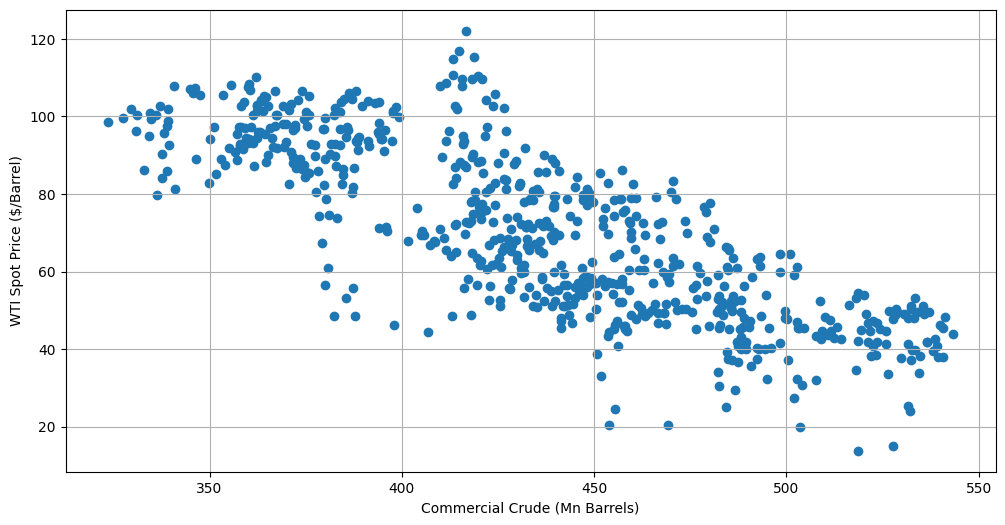

In [16]:
plt.scatter(x=inv['Commercial Crude'], y=prices_day_of['Close'])
plt.xlabel('Commercial Crude (Mn Barrels)')
plt.ylabel('WTI Spot Price ($/Barrel)')

<h2 align="left"> <font color='32a8a6'>Adjusting for inflation</font></h2>

<div class="alert alert-block alert-info">
    In 2011, the annual average CPI was 224.939; in 2023, it was 304.702. This represents an inflation rate of 35.5% over 12 years.
    <br>
    Therefore, for a given inventory level, the price in 2011 would have been roughly 74% of the price today. To account for this discrepancy, we can use the average CPI inflation of 2.65% to adjust Crude prices for inflation YOY.
</div>

In [17]:
av_cpi = 0.0265
days_per_year = 365.2425

In [18]:
today = dt.datetime.now(tz=wall_st)
years_ago = (today - prices_day_of.index).days // days_per_year

In [19]:
inflation_adjs = (1 + av_cpi) ** years_ago.to_numpy()

In [20]:
inflation_adjs[0] # close enough to 35.5%

1.3686974069826918

In [21]:
# Inflation-adjusted Open and Close prices
close_prices_adj = prices_day_of.Close * inflation_adjs
open_prices_adj = prices_day_of.Open * inflation_adjs

In [22]:
inv.corrwith(close_prices_adj).sort_values(ascending=False, key=abs)

Total Stocks (Excluding SPR)   -0.906603
Commercial Crude               -0.860806
Other Oils                     -0.616259
Total Stocks (Including SPR)   -0.584861
Total Motor Gasoline           -0.559176
Distillate Fuel Oil            -0.505219
Fuel Ethanol                   -0.501021
Propane/Propylene              -0.477687
Unfinished Oils                -0.303073
Crude Oil                      -0.299108
Kerosene-Type Jet Fuel         -0.175096
SPR                             0.095811
Residual Fuel Oil              -0.053807
dtype: float64

<div class="alert alert-block alert-info">
    Recalculating the PCC between inventory levels and inflation-adjusted price, we see an improved coefficient of <b>-0.907</b> compared to <b>-0.838</b> for unadjusted price.
    <br><br>
    Plotting the distribution, there variation of the data is noticeably smaller than previously: 
</div>

Text(0, 0.5, 'WTI Spot Price ($/Barrel)')

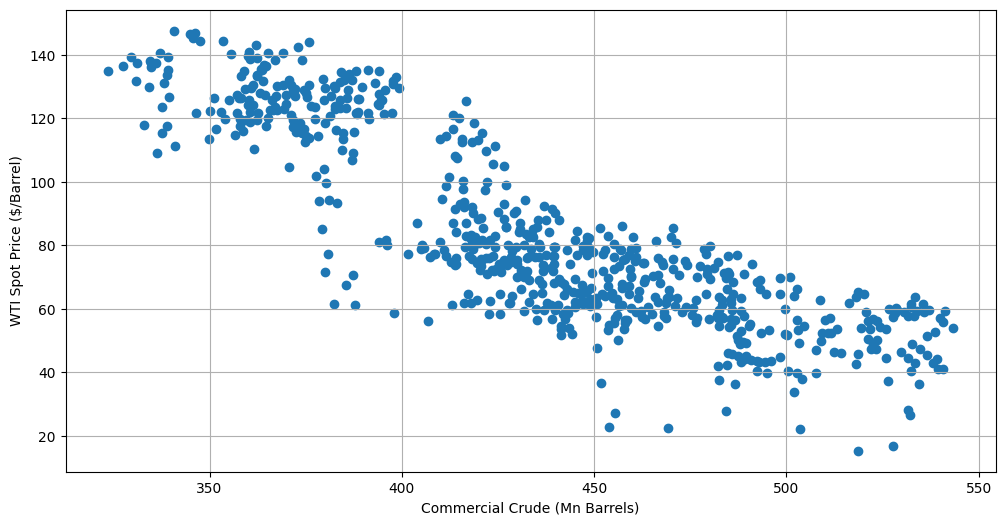

In [23]:
plt.scatter(x=inv['Commercial Crude'], y=close_prices_adj)
plt.xlabel('Commercial Crude (Mn Barrels)')
plt.ylabel('WTI Spot Price ($/Barrel)')

<h1>Predicting <i>Fair</i> Price</h1>

<div class="alert alert-block alert-info">
    To <i>predict</i> the `fair` WTI price, we can train a Regression model. We will consider two approaches:
    <ol>
        <li><b>Univariate</b> - using a single inventory level to predict price</li>
        <li><b>Multivariate</b> - using all inventory levels to predict price</li>
    </ol>
    We will not be able to visualise the multivariate approach, but assume that it will be able to identify a more complex relationship between the inventory levels and price in higher dimensions that the univariate approach.
</div>

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator

from typing import Optional

In [25]:
def evaluate_model(model: BaseEstimator, X: np.ndarray, y:np.array,
                   random_state: int = 0,
                   train_size: float = 0.5,
                   return_score: Optional[str] = None,
                   plot: bool = False,
                   quiet:bool = False):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)

    model.fit(X_train, y_train)

    score = model.score(X_test, y_test)

    scores = dict()
    scores['r2'] = model.score(X, y)
    scores['mae'] = mean_absolute_error(y, model.predict(X))
    scores['medae'] = median_absolute_error(y, model.predict(X))
    
    if not quiet:
        print(f'{'Performance':-^19s}')
        print(f'{'R2 Test':>9s}:{score:>9.3f}')
        print(f'{'R2 Full':>9s}:{scores['r2']:>9.3f}')
        print()
        print(f'{'Metrics':-^19s}')
        print(f'{'MAE':>9s}:{scores['mae']:>9.3f}')
        print(f'{'MedAE':>9s}:{scores['medae']:>9.3f}')
        print()
        print(f'{'Pricing':-^19s}')
        print(f'{'Pred.':>9s}:{model.predict(X[-1].reshape(1, -1))[0]:>9.3f}')
        print(f'{'Latest':>9s}:{y[-1]:>9.3f}')

    if plot:
        y_pred = model.predict(X)

        plt.scatter(x=X, y=y)
        plt.plot(X, y_pred, color='red')
        plt.xlabel('Commercial Crude (Mn Barrels)')
        plt.ylabel('WTI Spot Price ($/Barrel)')
        
    if return_score:
        if return_score not in scores:
            raise ValueError('Invalid score name')
        return scores[return_score]
        
    return 

<h2 align="left"> <font color='32a8a6'>Model 1 - Univariate Linear Regression</font></h2>

<div class="alert alert-block alert-info">
    The sklearn <code>LinearRegression</code> model implements an Ordinary Least Squares (OLS) algorithm. Based on the correlation coefficients we calculating above, Total Stocks (Excluding SPR) would be the obvious choice here.
</div>

In [26]:
from sklearn.linear_model import LinearRegression

In [27]:
feature = 'Total Stocks (Excluding SPR)'
X = inv[feature].to_numpy().reshape(-1, 1)
y = close_prices_adj.to_numpy()
model1 = LinearRegression()

----Performance----
  R2 Test:    0.824
  R2 Full:    0.822

------Metrics------
      MAE:    9.576
    MedAE:    7.517

------Pricing------
    Pred.:   79.122
   Latest:   78.630


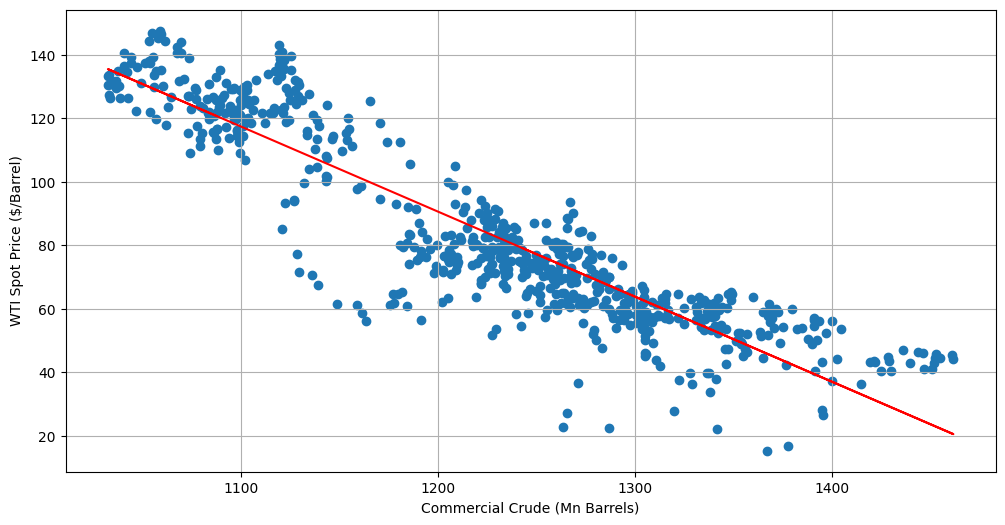

In [28]:
evaluate_model(model1, X, y, plot=True)

<h2 align="left"> <font color='32a8a6'>Model 2 - Univariate 'Polynomial' Regression</font></h2>

<div class="alert alert-block alert-info">
    From the graph above, we can see the an Ordinary Least Squares regression approximate the price for low-to-mid inventory levels well. However, the relationship appears to become non-linear towards higher inventory levels.
    <br><br>
    To create a model that is able to adapt to this, we can using the <code>PolynomailFeatures</code> preprocessing class from sklearn to project our linear variables into polynomial space. Using a 2nd-degree polynomial, this will allow our model to predict a curved relationship.
</div>

In [29]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [30]:
model2 = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

----Performance----
  R2 Test:    0.854
  R2 Full:    0.848

------Metrics------
      MAE:    8.529
    MedAE:    6.579

------Pricing------
    Pred.:   74.987
   Latest:   78.630


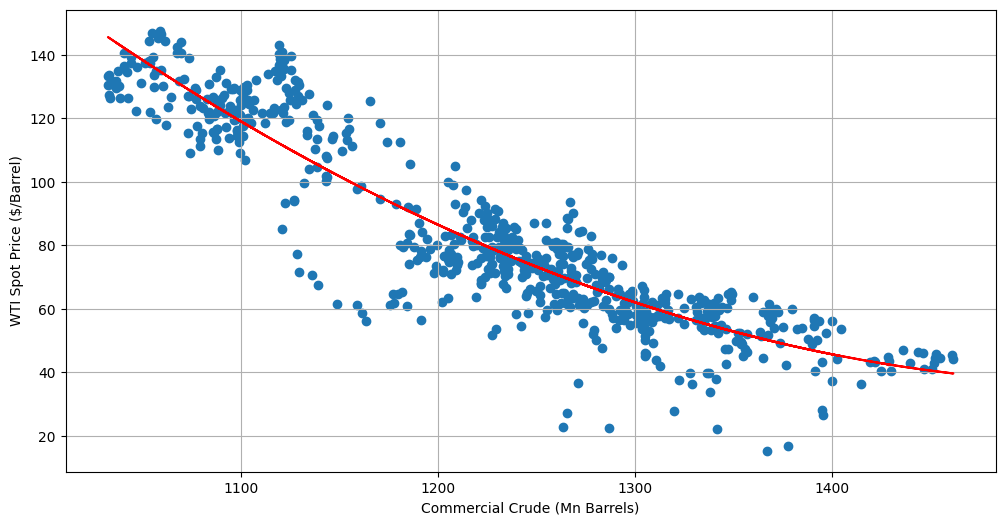

In [31]:
evaluate_model(model2, X, y, plot=True)

<h2 align="left"> <font color='32a8a6'>Model 3 - Multivariate Linear Regression</font></h2>

<div class="alert alert-block alert-info">
    The coefficient estimates for OLS rely on the <b>independence of the features</b>. When features are correlated and the columns of the design matrix have an approximately linear dependence, the design matrix becomes close to singular and as a result, the least-squares estimate becomes highly sensitive to random errors in the observed target, producing a large variance. <a href=https://scikit-learn.org/stable/modules/linear_model.html>(Source)</a>
    <br>
    We can check for <b>Collinearity</b> between our features by calculating the PCC between each of them:
</div>

In [32]:
inv.corr()

,Crude Oil,Total Motor Gasoline,Fuel Ethanol,Kerosene-Type Jet Fuel,Distillate Fuel Oil,Residual Fuel Oil,Propane/Propylene,Other Oils,Unfinished Oils,Total Stocks (Including SPR),Total Stocks (Excluding SPR),SPR,Commercial Crude
Crude Oil,1.000000,0.245258,-0.290999,0.213194,0.647444,0.653222,-0.018601,-0.164071,0.170868,0.918560,0.300867,0.893196,0.355700
Total Motor Gasoline,0.245258,1.000000,0.555807,0.165355,0.462463,-0.011512,-0.157830,0.176693,0.236472,0.393421,0.536422,0.003790,0.534668
Fuel Ethanol,-0.290999,0.555807,1.000000,0.100262,-0.014123,-0.473319,0.000393,0.416340,0.229291,-0.089996,0.441720,-0.525420,0.448314
Kerosene-Type Jet Fuel,0.213194,0.165355,0.100262,1.000000,0.420449,0.154933,0.078468,0.069756,0.162437,0.297221,0.233138,0.162821,0.133204
Distillate Fuel Oil,0.647444,0.462463,-0.014123,0.420449,1.000000,0.507823,0.237777,0.102797,-0.105721,0.788216,0.608991,0.440418,0.516863
Residual Fuel Oil,0.653222,-0.011512,-0.473319,0.154933,0.507823,1.000000,0.017632,-0.430048,-0.106813,0.538891,0.107122,0.588497,0.221873
Propane/Propylene,-0.018601,-0.157830,0.000393,0.078468,0.237777,0.017632,1.000000,0.541643,-0.147045,0.256267,0.522315,-0.158216,0.287694
Other Oils,-0.164071,0.176693,0.416340,0.069756,0.102797,-0.430048,0.541643,1.000000,0.346374,0.185958,0.727655,-0.438821,0.549109
Unfinished Oils,0.170868,0.236472,0.229291,0.162437,-0.105721,-0.106813,-0.147045,0.346374,1.000000,0.215068,0.266534,0.026891,0.322093
Total Stocks (Including SPR),0.918560,0.393421,-0.089996,0.297221,0.788216,0.538891,0.256267,0.185958,0.215068,1.000000,0.629489,0.691771,0.594193


<div class="alert alert-block alert-info">
    As expected, the <b>Total Stocks</b> features show signficant linearity with the individual inventory features, since they are a sum of all their values.
    To train an OLS model with multivariate input features, we must first drop these columns. Furthermore, since the SPR level is controlled by Government policy, it can not be treated as a random variable impacted by supply and demand. Therefore we must drop this too. 
</div>

In [33]:
inv = inv.drop(['Total Stocks (Including SPR)', 'Total Stocks (Excluding SPR)', 'Crude Oil', 'SPR'], axis=1)

<h3>Normalising the data</h3>

<div class="alert alert-block alert-info">
    The Linear Regression model may be sensitive to the relative magnitudes of the different inventory levels. By plotting the distributions of each inventory, we see that they are approximately normally distributed, although some show greater levels of kurtosis than others. 
    <br><br>
    To normalise the data before training the model, we will use the sklearn <code>RobustScaler</code>, which uses percentile values to centre and scale the data, meaning it is not influenced by a small number of very large marginal outliers.
</div>

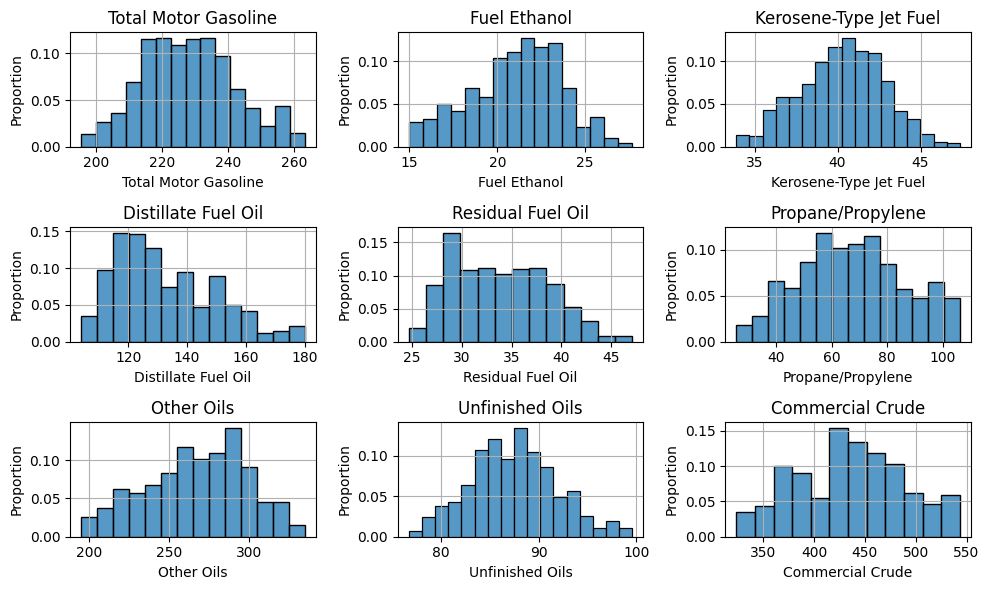

In [34]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(10, 6))
axes = axes.flatten()     

for ax, col in zip(axes, inv.columns):
  sns.histplot(inv[col], ax = ax, stat='proportion')
  ax.set_title(col)

fig.tight_layout()

In [35]:
from sklearn.preprocessing import RobustScaler

In [36]:
X = inv.to_numpy()
y = close_prices_adj.to_numpy()

In [37]:
model3 = make_pipeline(RobustScaler(), LinearRegression())

In [38]:
evaluate_model(model3, X, y)

----Performance----
  R2 Test:    0.866
  R2 Full:    0.870

------Metrics------
      MAE:    8.566
    MedAE:    7.293

------Pricing------
    Pred.:   76.101
   Latest:   78.630


In [39]:
pd.Series(model3.named_steps['linearregression'].coef_, index=inv.columns).sort_values(ascending=False, key=abs)

Commercial Crude         -25.942302
Propane/Propylene        -19.303823
Total Motor Gasoline      -8.859141
Unfinished Oils           -7.140166
Distillate Fuel Oil       -6.318443
Residual Fuel Oil          5.461987
Other Oils                 4.736594
Fuel Ethanol              -4.467836
Kerosene-Type Jet Fuel     1.950248
dtype: float64

<h2 align="left"> <font color='32a8a6'>Model 4 - Multivariate 'Polynomial' Regression</font></h2>

In [40]:
model4 = make_pipeline(RobustScaler(), PolynomialFeatures(degree=2), LinearRegression())

In [41]:
evaluate_model(model4, X, y)

----Performance----
  R2 Test:    0.922
  R2 Full:    0.941

------Metrics------
      MAE:    5.522
    MedAE:    4.271

------Pricing------
    Pred.:   77.000
   Latest:   78.630


<h2 align="left"> <font color='32a8a6'>Model 5 - Multivariate 'Polynomial' LASSO Regression</font></h2>

In [42]:
from sklearn.linear_model import LassoCV

In [43]:
model5 = make_pipeline(RobustScaler(), PolynomialFeatures(degree=2), LassoCV())

In [44]:
evaluate_model(model5, X, y)

----Performance----
  R2 Test:    0.927
  R2 Full:    0.943

------Metrics------
      MAE:    5.538
    MedAE:    4.549

------Pricing------
    Pred.:   76.530
   Latest:   78.630


<h1>Testing the models</h1>

In [45]:
random_states = np.random.randint(0, 1000, 100)
train_size = 0.66
model_scores = []

X = inv['Commercial Crude'].to_numpy().reshape(-1, 1)
y = close_prices_adj.to_numpy()

for model in [model1, model2]:
    scores = []
    for random_state in random_states:

        score = evaluate_model(model, X, y, 
                               random_state=random_state,
                               train_size=train_size,
                               return_score='medae',
                               quiet=True)
        scores.append(score)
    model_scores.append(scores)

X = inv.to_numpy()
y = close_prices_adj.to_numpy()

for model in [model3, model4, model5]:
    scores = []

    for random_state in random_states:

        score = evaluate_model(model, X, y, 
                               random_state=random_state, 
                               train_size=train_size, 
                               return_score='medae',
                               quiet=True)
        scores.append(score)

    model_scores.append(scores)
    

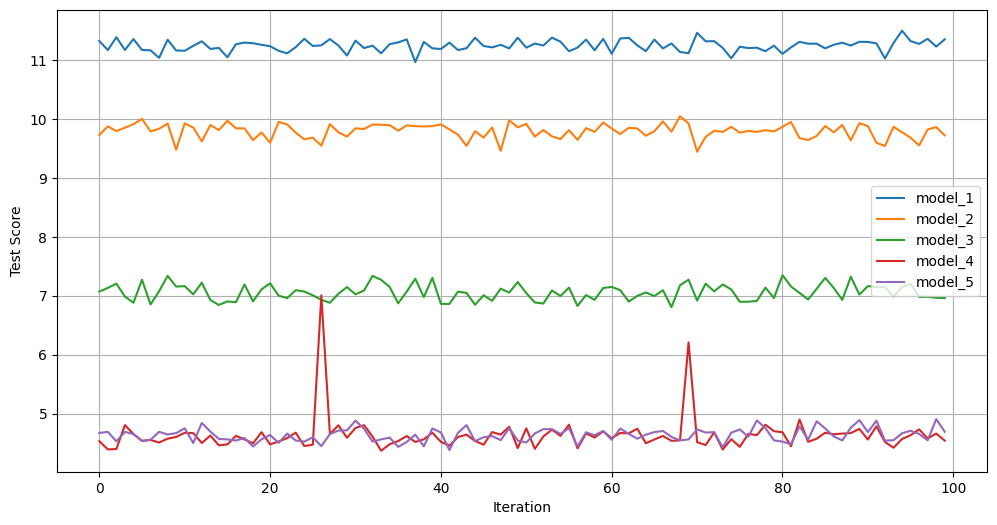

In [46]:
x = np.arange(100)
plt.plot(x, model_scores[0], label='model_1')
plt.plot(x, model_scores[1], label='model_2')
plt.plot(x, model_scores[2], label='model_3')
plt.plot(x, model_scores[3], label='model_4')
plt.plot(x, model_scores[4], label='model_5')
plt.xlabel('Iteration')
plt.ylabel('Test Score')
plt.legend()

<h1>Conclusion</h1>

In [47]:
dtr = (close_prices_adj - open_prices_adj).abs().mean()
round(dtr, 3)

1.316

In [48]:
round(np.mean(model_scores[3]), 3)

4.634

In [49]:
round(np.mean(model_scores[4]), 3)

4.635

<div class="alert alert-block alert-info">
    Model 4 generates an improved R2 (coefficient of determination) of <b>0.922</b> for the test data and an average Median Absolute Error of <b>\$4.605</b>, however, it is more sensitive to anomalies in the underlying data as shown by its significant underperformance compared to Models 1-3 in the plot above which suggests overfitting.
    Using the regularised LASSO regression in Model 5 with default 5-fold Cross Validation, we can achieve comparable performance with a more robust model. This model has a higher R2 test score of <b>0.927</b> with a similar average Median Absolute Error of <b>$4.619</b>.
    <br><br>
    Over the analysed 11-year time period, the average Daily Traded Range of WTI over this period is <b>\$1.316</b>. Therefore, these models alone may be used to predict an approximate `fair` price for longer term strategies but would not be suitable for intraday or short-term trading where price movements are likely to stay within the uncertainty region of the model. 
</div>

<h1>Visualising Model Predictions</h1>

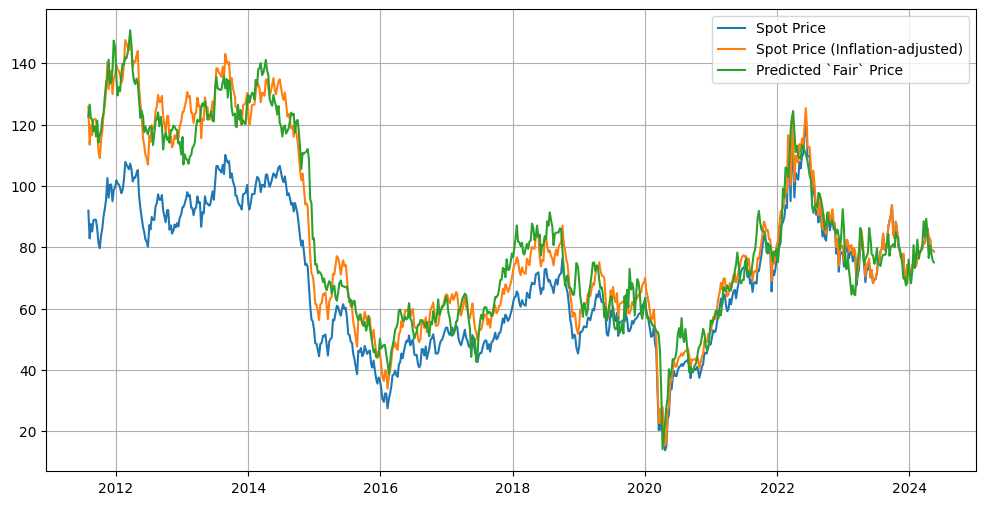

In [50]:
plt.plot(prices_day_of.index, prices_day_of.Close, label='Spot Price')
plt.plot(prices_day_of.index, close_prices_adj,label='Spot Price (Inflation-adjusted)')
plt.plot(prices_day_of.index, model5.predict(X), label='Predicted `Fair` Price')
plt.legend()